# Question One

Data Collection:BP Equity Price Movement for the period January 2021 to January 2023

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = yf.download('BP', start='2021-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


In [4]:
data['Return'] = data['Close'].pct_change()

### Calculate annualized average return

In [5]:
avg_return = data['Return'].mean() * 252
print(f'Annualized Average Return: {avg_return * 100:.2f}%')

Annualized Average Return: 31.96%


### Calculate annualized standard deviation

In [7]:
std_dev = data['Return'].std() * np.sqrt(252)
print(f'Annualized Standard Deviation: {std_dev * 100:.2f}%')

Annualized Standard Deviation: 34.65%


# Plot equity price movement

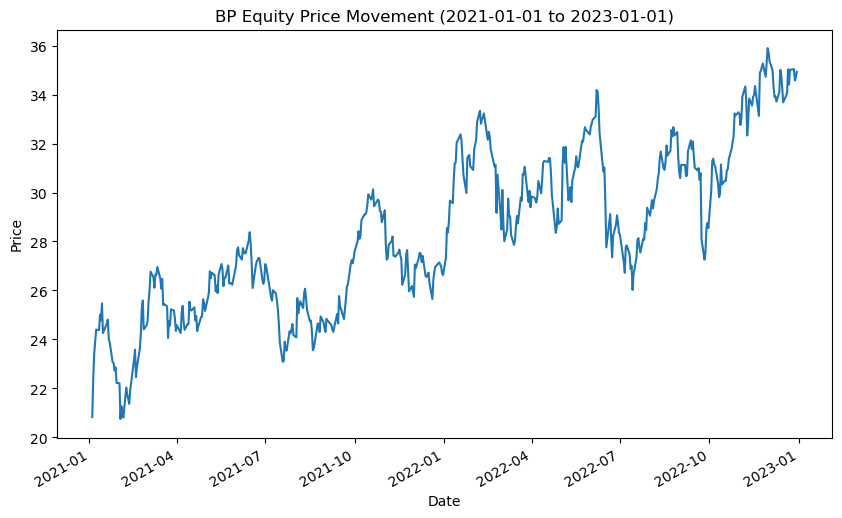

In [8]:
plt.figure(figsize=(10,6))
data['Close'].plot()
plt.title('BP Equity Price Movement (2021-01-01 to 2023-01-01)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Question Two

### Option Pricing models

In [13]:
data_ac = data['Adj Close']
data_ac.head()

Date
2021-01-04    18.143101
2021-01-05    19.493162
2021-01-06    20.390299
2021-01-07    20.825804
2021-01-08    21.252602
Name: Adj Close, dtype: float64

In [14]:
S0 = data_ac[-1:]     # spot price = 33.395939
K = 34.93             # strike price
T = 1                 # maturity 1 year
r = 0.05              # risk free rate 
sig = std_dev         # diffusion coefficient or volatility
N = 3                 # number of periods or number of time steps  
payoff = "put"        # payoff 

print(S0)

Date
2022-12-30    33.395939
Name: Adj Close, dtype: float64


Binomial tree

1. Creating a Binomial Tree

In [41]:
dT = float(T) / N                    # Delta t
u = np.exp(sig * np.sqrt(dT))        # up factor
d = 1.0 / u                          # down factor 

S1 = np.zeros((N + 1, N + 1))
S1[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S1[i, t] = S1[i, t-1] * u
        S1[i+1, t] = S1[i, t-1] * d
    z += 1

/var/folders/pf/2yrfy0312gd90711pgn3w2mw0000gn/T/ipykernel_74508/1697959993.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S1[0, 0] = S0


In [16]:
print('The up factor u is ',(u))

The up factor u is  1.2214951509402452


In [17]:
print('The down factor d is ',(d))

The down factor d is  0.8186688250299239


In [18]:
print('The binomial tree presenting Polka Dot price over 3 time steps ', '\n', (S1))

The binomial tree presenting Polka Dot price over 3 time steps  
 [[33.39593887 40.79297739 49.82842408 60.86517839]
 [ 0.         27.34021404 33.39593887 40.79297739]
 [ 0.          0.         22.3825809  27.34021404]
 [ 0.          0.          0.         18.32392121]]


In [19]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
print('Risk-neutral porbability is ', (p))

Risk-neutral porbability is  0.4918683129971181


### Option value at each final nodes

In [20]:
S_T = S1[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  7.58978596],
       [ 0.        ,  0.        ,  0.        , 16.60607879]])

### Option value at earlier nodes

In [21]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
print('The option values at earlier nodes ', '\n', (V))

The option values at earlier nodes  
 [[ 4.82309985  1.89542063  0.          0.        ]
 [ 0.          7.81659797  3.79286658  0.        ]
 [ 0.          0.         11.97007698  7.58978596]
 [ 0.          0.          0.         16.60607879]]


In [22]:
print('Binomial tree & Option price - European ' + payoff, str( V[0,0]))

Binomial tree & Option price - European put 4.823099847219134


### Monte Carlo Pricing Model

In [23]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * rn[t]) 
    return S

In [24]:
S2 = mcs_simulation_np(1000)

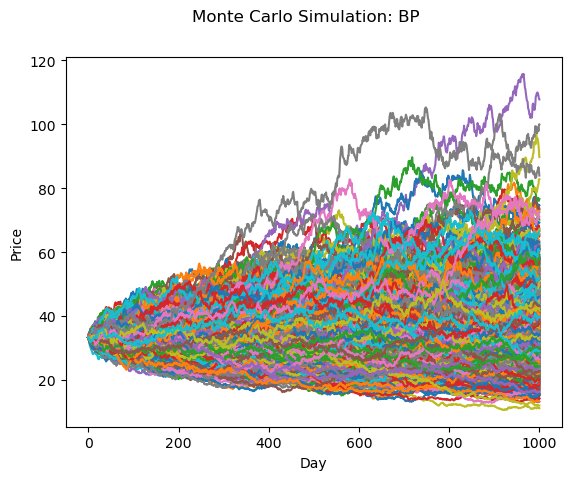

In [25]:
fig = plt.figure()
plt.plot(S2)
fig.suptitle('Monte Carlo Simulation: BP')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [26]:
S2 = np.transpose(S2)
S2

array([[33.39593887, 34.47518539, 33.87590761, ..., 30.24488315,
        30.5273198 , 29.8140625 ],
       [33.39593887, 33.45449594, 33.63846311, ..., 27.23245422,
        27.59882378, 27.33992556],
       [33.39593887, 33.54554434, 33.24546838, ..., 40.91961464,
        41.11708448, 41.26857408],
       ...,
       [33.39593887, 33.02968153, 32.80269941, ..., 86.59224075,
        85.57486443, 83.96958767],
       [33.39593887, 33.2606417 , 33.20321596, ..., 42.49007704,
        42.00004633, 41.84325091],
       [33.39593887, 33.00652542, 33.06935648, ..., 39.67421893,
        39.77925604, 39.64831201]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

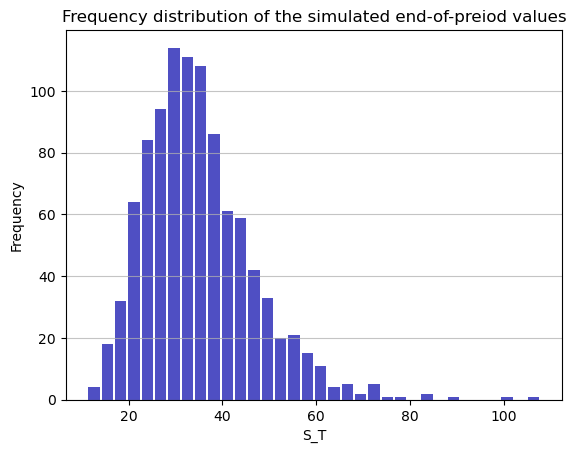

In [27]:
n, bins, patches = plt.hist(x=S2[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [28]:
put = np.mean(np.maximum(K - S2[:,-1],0))
print('Monte Carlo Simulation & Option price - European put', str(put))

Monte Carlo Simulation & Option price - European put 4.404966491308899


# Question Three

### Greeks for Risk Management Purpose

### Black-scholes option value

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

In [44]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * std_dev ** 2) * T) / (std_dev * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * std_dev ** 2) * T) / (std_dev * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [45]:
Bsm = euro_option_bsm(S0, K, T, r, 0, std_dev, 'put')            #q: dividend = 0
print('Black-scholes & Option price - European put', str(put))

Black-scholes & Option price - European put 4.404966491308899


### Delta

In [46]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [48]:
delta(S0, K, T, r, 0, std_dev, 'put')

array([-0.42545654])

In [49]:
S11 = np.linspace(3,15,11)
Delta_Call = np.zeros((len(S11),1))
Delta_Put = np.zeros((len(S11),1))
for i in range(len(S11)):
    Delta_Put [i] = delta(S11[i], K, T, r, 0, std_dev, 'put')

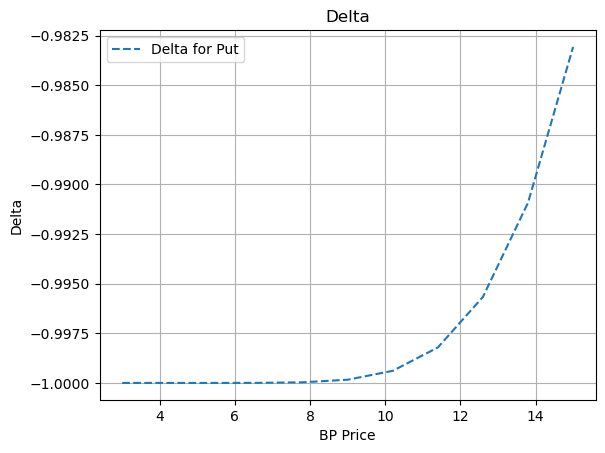

In [50]:
fig = plt.figure()

plt.plot(S11, Delta_Put, '--')
plt.grid()
plt.xlabel('BP Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

### Gamma

In [51]:
def gamma(S, K, T, r,  vol, payoff):
    
    d1 = (np.log(S / K) + (r  + 0.5 * std_dev ** 2) * T) / (vol * np.sqrt(T))

    gamma = si.norm.pdf(d1, 0.0, 1.0) / (vol *  np.sqrt(T) * S)

    
    return gamma

In [52]:
gamma(33.39, 34.93, 1, 0.05, 0.347, 'put')

0.033834137549740566

In [53]:
S = np.linspace(50,150,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 34.93, 1, 0.05, 0.347, 'put')

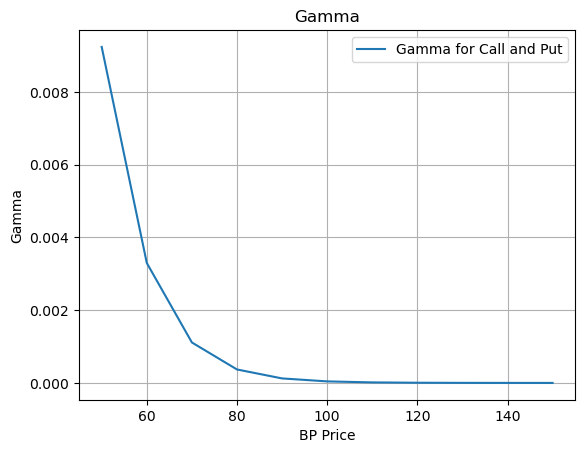

In [54]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('BP Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

### Theta

In [60]:
def theta(S, K, T, r, std_dev, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * std_dev ** 2) * T) / (std_dev * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * std_dev ** 2) * T) / (std_dev * np.sqrt(T))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    
    if payoff == "call":
        theta = - S * N_d1_prime * std_dev / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = - S * N_d1_prime * std_dev / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [61]:
theta(33.39, 34.93, 1, 0.05, 0.347, 'put')

-1.3349757898578596

In [62]:
T = np.linspace(0.25,3,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(100, 100, T[i], 0.05, 0.25, 'call')
    Theta_Put [i] = theta(100, 100, T[i], 0.05, 0.25, 'put')

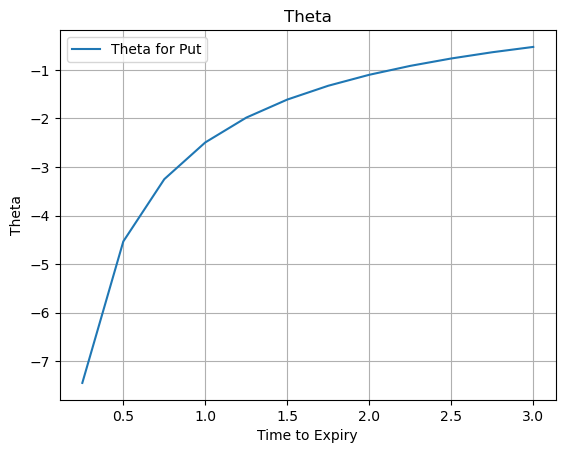

In [65]:
fig = plt.figure()
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

### Vega

In [72]:
def vega(S, K, T, r, std_dev, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * std_dev ** 2) * T) / (std_dev * np.sqrt(T))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    vega = S * np.sqrt(T) * N_d1_prime
    
    return vega

In [73]:
vega(33.39, 34.93, 1, 0.05, 0.347, 'put')

13.088205391563797

In [74]:
vol = np.linspace(0.1,0.4,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(100, 100, 1, 0.05, vol[i], 'put')

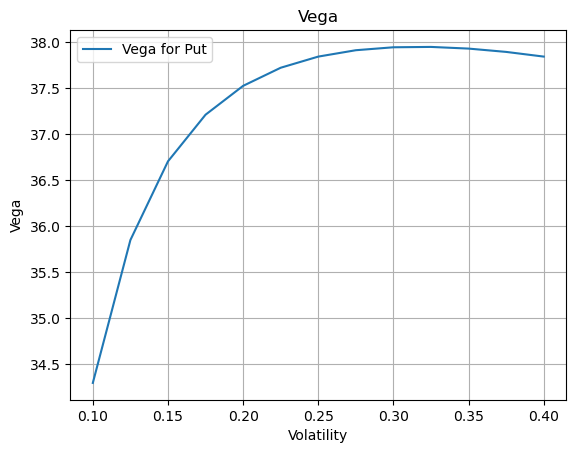

In [75]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Put'])